# GGH
## GHH
hhjkl;


# DDPG
Add code 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

import argparse
from distutils.util import strtobool
import collections
import numpy as np
import gym
from gym.wrappers import TimeLimit, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space
import time
import random
import os
import matplotlib.pyplot as plt
import time
import argparse
import datetime

In [2]:
class ReplayBuffer(object):
    """
    A simple FIFO experience replay buffer for agents.
    """

    def __init__(self, obs_dim, act_dim, size, device):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
        self.device = device

    def add(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample(self, batch_size=64):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=torch.Tensor(self.obs1_buf[idxs]).to(self.device),
                    obs2=torch.Tensor(self.obs2_buf[idxs]).to(self.device),
                    acts=torch.Tensor(self.acts_buf[idxs]).to(self.device),
                    rews=torch.Tensor(self.rews_buf[idxs]).to(self.device),
                    done=torch.Tensor(self.done_buf[idxs]).to(self.device))


class Buffer(object):
    """
    A buffer for storing trajectories experienced by a agent interacting
    with the environment.
    """

    def __init__(self, obs_dim, act_dim, size, device, gamma=0.99, lam=0.97):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.act_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.don_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.v_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.max_size = 0, size
        self.device = device

    def add(self, obs, act, rew, don, v):
        assert self.ptr < self.max_size      # Buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.don_buf[self.ptr] = don
        self.v_buf[self.ptr] = v
        self.ptr += 1

    def finish_path(self):
        previous_v = 0
        running_ret = 0
        running_adv = 0
        for t in reversed(range(len(self.rew_buf))):
            # The next two line computes rewards-to-go, to be targets for the value function
            running_ret = self.rew_buf[t] + self.gamma*(1-self.don_buf[t])*running_ret
            self.ret_buf[t] = running_ret

            # The next four lines implement GAE-Lambda advantage calculation
            running_del = self.rew_buf[t] + self.gamma*(1-self.don_buf[t])*previous_v - self.v_buf[t]
            running_adv = running_del + self.gamma*self.lam*(1-self.don_buf[t])*running_adv
            previous_v = self.v_buf[t]
            self.adv_buf[t] = running_adv
        # The next line implement the advantage normalization trick
        self.adv_buf = (self.adv_buf - self.adv_buf.mean()) / self.adv_buf.std()
        
    def get(self):
        assert self.ptr == self.max_size     # Buffer has to be full before you can get
        self.ptr = 0
        return dict(obs=torch.Tensor(self.obs_buf).to(self.device),
                    act=torch.Tensor(self.act_buf).to(self.device),
                    ret=torch.Tensor(self.ret_buf).to(self.device),
                    adv=torch.Tensor(self.adv_buf).to(self.device),
                    v=torch.Tensor(self.v_buf).to(self.device))

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env = gym.make('Humanoid-v2')
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]

print (obs_dim, act_dim, act_limit)

376 17 0.4


In [4]:
# Hyper params
n_iters = 30
steps_per_iter = 4000
phase = 'train'
max_step = 1000

In [5]:
def identity(x):
    """Return input without any change."""
    return x

class MLP(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size, 
                 output_limit=1.0,
                 hidden_sizes=(64,64), 
                 activation=F.relu, 
                 output_activation=identity,
                 use_output_layer=True,
                 use_actor=False,
    ):
        super(MLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.output_limit = output_limit
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.output_activation = output_activation
        self.use_output_layer = use_output_layer
        self.use_actor = use_actor

        # Set hidden layers
        self.hidden_layers = nn.ModuleList()
        in_size = self.input_size
        for next_size in self.hidden_sizes:
            fc = nn.Linear(in_size, next_size)
            in_size = next_size
            self.hidden_layers.append(fc)

        # Set output layers
        if self.use_output_layer:
            self.output_layer = nn.Linear(in_size, self.output_size)
        else:
            self.output_layer = identity

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_activation(self.output_layer(x))
        # If the network is used as actor network, make sure output is in correct range
        x = x * self.output_limit if self.use_actor else x   
        return x
    
"""
DDPG critic
"""
class FlattenMLP(MLP):
    def forward(self, x, a):
        q = torch.cat([x,a], dim=-1)
        return super(FlattenMLP, self).forward(q)
    
def hard_target_update(main, target):
    target.load_state_dict(main.state_dict())

def soft_target_update(main, target, tau=0.005):
    for main_param, target_param in zip(main.parameters(), target.parameters()):
        target_param.data.copy_(tau*main_param.data + (1.0-tau)*target_param.data)



In [6]:
class Agent(object):
   """An implementation of the Deep Deterministic Policy Gradient (DDPG) agent."""

   def __init__(self,
                env,
                device,
                obs_dim,
                act_dim,
                act_limit,
                steps=0,
                expl_before=2000,
                train_after=1000,
                gamma=0.99,
                act_noise=0.1,
                hidden_sizes=(128,128),
                buffer_size=int(1e4),
                batch_size=64,
                policy_lr=3e-4,
                qf_lr=3e-4,
                gradient_clip_policy=0.5,
                gradient_clip_qf=1.0,
                eval_mode=False,
                policy_losses=list(),
                qf_losses=list(),
                logger=dict(),
   ):

      self.env = env
      self.device = device
      self.obs_dim = obs_dim
      self.act_dim = act_dim
      self.act_limit = act_limit
      self.steps = steps 
      self.expl_before = expl_before
      self.train_after = train_after
      self.gamma = gamma
      self.act_noise = act_noise
      self.hidden_sizes = hidden_sizes
      self.buffer_size = buffer_size
      self.batch_size = batch_size
      self.policy_lr = policy_lr
      self.qf_lr = qf_lr
      self.gradient_clip_policy = gradient_clip_policy
      self.gradient_clip_qf = gradient_clip_qf
      self.eval_mode = eval_mode
      self.policy_losses = policy_losses
      self.qf_losses = qf_losses
      self.logger = logger

      # Main network
      self.policy = MLP(self.obs_dim, self.act_dim, self.act_limit, 
                                    hidden_sizes=self.hidden_sizes, 
                                    output_activation=torch.tanh,
                                    use_actor=True).to(self.device)
      self.qf = FlattenMLP(self.obs_dim+self.act_dim, 1, hidden_sizes=self.hidden_sizes).to(self.device)
      # Target network
      self.policy_target = MLP(self.obs_dim, self.act_dim, self.act_limit,
                                           hidden_sizes=self.hidden_sizes, 
                                           output_activation=torch.tanh,
                                           use_actor=True).to(self.device)
      self.qf_target = FlattenMLP(self.obs_dim+self.act_dim, 1, hidden_sizes=self.hidden_sizes).to(self.device)
      
      # Initialize target parameters to match main parameters
      hard_target_update(self.policy, self.policy_target)
      hard_target_update(self.qf, self.qf_target)

      # Create optimizers
      self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=self.policy_lr)
      self.qf_optimizer = optim.Adam(self.qf.parameters(), lr=self.qf_lr)
      
      # Experience buffer
      self.replay_buffer = ReplayBuffer(self.obs_dim, self.act_dim, self.buffer_size, self.device)

   def select_action(self, obs):
      action = self.policy(obs).detach().cpu().numpy()
      action += self.act_noise * np.random.randn(self.act_dim)
      return np.clip(action, -self.act_limit, self.act_limit)

   def train_model(self):
      batch = self.replay_buffer.sample(self.batch_size)
      obs1 = batch['obs1']
      obs2 = batch['obs2']
      acts = batch['acts']
      rews = batch['rews']
      done = batch['done']

      if 0: # Check shape of experiences
         print("obs1", obs1.shape)
         print("obs2", obs2.shape)
         print("acts", acts.shape)
         print("rews", rews.shape)
         print("done", done.shape)

      # Prediction Q(s,𝜇(s)), Q(s,a), Q‾(s',𝜇‾(s'))
      q_pi = self.qf(obs1, self.policy(obs1))
      q = self.qf(obs1, acts).squeeze(1)
      q_pi_target = self.qf_target(obs2, self.policy_target(obs2)).squeeze(1)
      
      # Target for Q regression
      q_backup = rews + self.gamma*(1-done)*q_pi_target
      q_backup.to(self.device)

      if 0: # Check shape of prediction and target
         print("q", q.shape)
         print("q_backup", q_backup.shape)

      # DDPG losses
      policy_loss = -q_pi.mean()
      qf_loss = F.mse_loss(q, q_backup.detach())

      # Update policy network parameter
      self.policy_optimizer.zero_grad()
      policy_loss.backward()
      nn.utils.clip_grad_norm_(self.policy.parameters(), self.gradient_clip_policy)
      self.policy_optimizer.step()
      
      # Update Q-function network parameter
      self.qf_optimizer.zero_grad()
      qf_loss.backward()
      nn.utils.clip_grad_norm_(self.qf.parameters(), self.gradient_clip_qf)
      self.qf_optimizer.step()

      # Polyak averaging for target parameter
      soft_target_update(self.policy, self.policy_target)
      soft_target_update(self.qf, self.qf_target)
      
      # Save losses
      self.policy_losses.append(policy_loss.item())
      self.qf_losses.append(qf_loss.item())

   def run(self, max_step, render):
      step_number = 0
      total_reward = 0.

      obs = self.env.reset()
      done = False

      # Keep interacting until agent reaches a terminal state.
      while not (done or step_number == max_step):
         if render:
            self.env.render()   

         if self.eval_mode:
            action = self.policy(torch.Tensor(obs).to(self.device))
            action = action.detach().cpu().numpy()
            next_obs, reward, done, _ = self.env.step(action)
         else:
            self.steps += 1

            # Until expl_before have elapsed, randomly sample actions 
            # from a uniform distribution for better exploration. 
            # Afterwards, use the learned policy.
            if self.steps > self.expl_before:
               action = self.select_action(torch.Tensor(obs).to(self.device))
            else:
               action = self.env.action_space.sample()

            # Collect experience (s, a, r, s') using some policy
            next_obs, reward, done, _ = self.env.step(action)

            # Add experience to replay buffer
            self.replay_buffer.add(obs, action, reward, next_obs, done)
            
            # Start training when the number of experience is greater than train_after
            if self.steps > self.train_after:
               self.train_model()

         total_reward += reward
         step_number += 1
         obs = next_obs
      
      # Save logs
      self.logger['LossPi'] = round(np.mean(self.policy_losses), 5)
      self.logger['LossQ'] = round(np.mean(self.qf_losses), 5)
      return step_number, total_reward

In [7]:
agent = Agent(env, device, obs_dim, act_dim, act_limit, 
                      expl_before=10000, 
                      act_noise=0.1, 
                      hidden_sizes=(256,256), 
                      buffer_size=int(1e6), 
                      batch_size=256,
                      policy_lr=3e-4, 
                      qf_lr=3e-4)

In [8]:

start_time = time.time()

total_num_steps = 0
train_sum_returns = 0.
train_num_episodes = 0
eval_mode = 0

train_avg_ret = []
train_ep_ret = []
eval_avg_ret = []
eval_ep_ret = []

# dir_name = 'runs/' + '/' \
#                            + 'ddpg' \
#                            + '_s_' + str(seed) \
#                            + '_t_' + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
# writer = SummaryWriter(log_dir=dir_name)

for i in range(n_iters):
        # Perform the training phase, during which the agent learns
        if phase == 'train':
            train_step_count = 0

            while train_step_count <= steps_per_iter:
                eval_mode = False
                
                # Run one episode
                train_step_length, train_episode_return = agent.run(max_step, False)
                
                total_num_steps += train_step_length
                train_step_count += train_step_length
                train_sum_returns += train_episode_return
                train_num_episodes += 1

                train_average_return = train_sum_returns / train_num_episodes if train_num_episodes > 0 else 0.0
                
                train_avg_ret.append(train_average_return)
                train_ep_ret.append(train_episode_return)
                
#                 writer.add_scalar('Train/AverageReturns', train_average_return, total_num_steps)
#                 writer.add_scalar('Train/EpisodeReturns', train_episode_return, total_num_steps)


        # Perform the evaluation phase -- no learning
        eval_sum_returns = 0.
        eval_num_episodes = 0
        eval_mode = True

        for _ in range(10):
            # Run one episode
            eval_step_length, eval_episode_return = agent.run(max_step, False)

            eval_sum_returns += eval_episode_return
            eval_num_episodes += 1

        eval_average_return = eval_sum_returns / eval_num_episodes if eval_num_episodes > 0 else 0.0
        eval_avg_ret.append(eval_average_return)
        eval_ep_ret.append(eval_episode_return)


        if phase == 'train':
            print('---------------------------------------')
            print('Iterations:', i + 1)
            print('Steps:', total_num_steps)
            print('Episodes:', train_num_episodes)
            print('EpisodeReturn:', round(train_episode_return, 2))
            print('AverageReturn:', round(train_average_return, 2))
            print('EvalEpisodes:', eval_num_episodes)
            print('EvalEpisodeReturn:', round(eval_episode_return, 2))
            print('EvalAverageReturn:', round(eval_average_return, 2))
            print('OtherLogs:', agent.logger)
            print('Time:', int(time.time() - start_time))
            print('---------------------------------------')

        
        print('---------------------------------------')
        print('EvalEpisodes:', eval_num_episodes)
        print('EvalEpisodeReturn:', round(eval_episode_return, 2))
        print('EvalAverageReturn:', round(eval_average_return, 2))
        print('Time:', int(time.time() - start_time))
        print('---------------------------------------')
            

/home/jasleen/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jasleen/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


---------------------------------------
Iterations: 1
Steps: 4039
Episodes: 166
EpisodeReturn: 244.69
AverageReturn: 119.78
EvalEpisodes: 10
EvalEpisodeReturn: 88.34
EvalAverageReturn: 126.59
OtherLogs: {'LossPi': -45.07494, 'LossQ': 5.37728}
Time: 17
---------------------------------------
---------------------------------------
EvalEpisodes: 10
EvalEpisodeReturn: 88.34
EvalAverageReturn: 126.59
Time: 17
---------------------------------------
---------------------------------------
Iterations: 2
Steps: 8052
Episodes: 336
EpisodeReturn: 82.12
AverageReturn: 117.82
EvalEpisodes: 10
EvalEpisodeReturn: 106.92
EvalAverageReturn: 119.62
OtherLogs: {'LossPi': -104.11557, 'LossQ': 19.47229}
Time: 38
---------------------------------------
---------------------------------------
EvalEpisodes: 10
EvalEpisodeReturn: 106.92
EvalAverageReturn: 119.62
Time: 38
---------------------------------------
---------------------------------------
Iterations: 3
Steps: 12072
Episodes: 450
EpisodeReturn: 241

---------------------------------------
Iterations: 20
Steps: 80576
Episodes: 3247
EpisodeReturn: 471.0
AverageReturn: 119.96
EvalEpisodes: 10
EvalEpisodeReturn: 556.83
EvalAverageReturn: 465.59
OtherLogs: {'LossPi': -173.44545, 'LossQ': 171.66862}
Time: 528
---------------------------------------
---------------------------------------
EvalEpisodes: 10
EvalEpisodeReturn: 556.83
EvalAverageReturn: 465.59
Time: 528
---------------------------------------
---------------------------------------
Iterations: 21
Steps: 84646
Episodes: 3299
EpisodeReturn: 505.53
AverageReturn: 123.83
EvalEpisodes: 10
EvalEpisodeReturn: 351.34
EvalAverageReturn: 437.69
OtherLogs: {'LossPi': -197.60222, 'LossQ': 276.41987}
Time: 558
---------------------------------------
---------------------------------------
EvalEpisodes: 10
EvalEpisodeReturn: 351.34
EvalAverageReturn: 437.69
Time: 558
---------------------------------------
---------------------------------------
Iterations: 22
Steps: 88687
Episodes: 3351


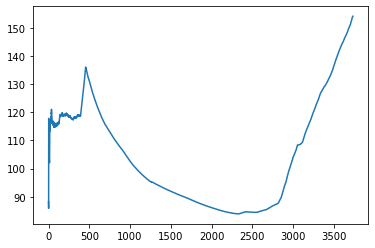

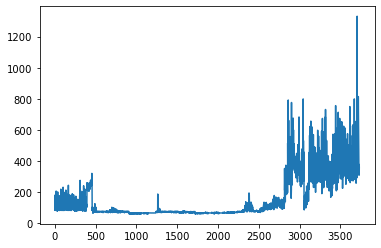

In [9]:
plt.show()
plt.plot(train_avg_ret)

plt.show()
plt.plot(train_ep_ret)

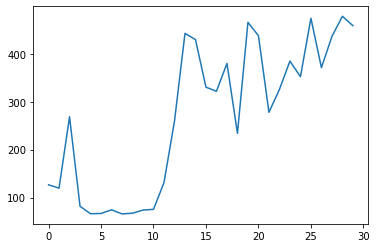

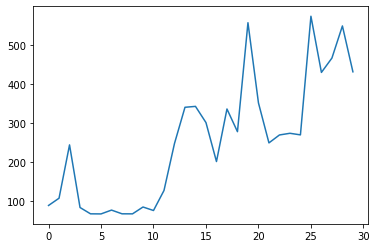

In [10]:
plt.show()
plt.plot(eval_avg_ret)

plt.show()
plt.plot(eval_ep_ret)

In [11]:
algo = "DDPG"
path = "Results/" + algo
np.save(path +"_train_avg", train_avg_ret)
np.save(path + "_test_avg", eval_avg_ret)
np.save(path +"_train_ep", train_ep_ret)
np.save(path + "_test_ep", eval_ep_ret)

In [14]:
for _ in range(100):
    # Run one episode
    eval_step_length, eval_episode_return = agent.run(max_step, True)

    eval_sum_returns += eval_episode_return
    eval_num_episodes += 1

NameError: name 'exit' is not defined